In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sales_data = pd.read_parquet('../Data/sales_data.parquet', engine='pyarrow')

In [51]:
def preprocess_data(sales_data):
    # Sorting by dept_id, shop_name, and billdate
    sales_data = sales_data.sort_values(by=['dept_id', 'shop_name', 'billdate'])
    # Drop irrelevant columns
    data = sales_data.drop(columns=['is_move_shop', 'dept_id'])
    # Filter out rows where target column is 0 or negative
    data = data[data['total_target_split_aftr_comp_profit'] > 0]
    return data

In [53]:
def feature_engineering(data, save_clusters=True):
    # 聚类特征
    if save_clusters:
        shop_features = data.groupby('shop_name').mean()
        kmeans = KMeans(n_clusters=3, n_init=10)
        data['shop_cluster'] = data['shop_name'].map(shop_features['total_target_split_aftr_comp_profit'].to_dict())
        data['shop_cluster'] = kmeans.fit_predict(data[['shop_cluster']])
        # 保存门店的聚类结果
        shop_cluster_mapping = data[['shop_name', 'shop_cluster']].drop_duplicates().set_index('shop_name').to_dict()['shop_cluster']
        with open("shop_cluster_mapping.pkl", "wb") as f:
            pickle.dump(shop_cluster_mapping, f)
    else:
        with open("shop_cluster_mapping.pkl", "rb") as f:
            shop_cluster_mapping = pickle.load(f)
        data['shop_cluster'] = data['shop_name'].map(shop_cluster_mapping)
    one_hot = OneHotEncoder(sparse_output=False)
    cluster_encoded = one_hot.fit_transform(data[['shop_cluster']])
    num_clusters = cluster_encoded.shape[1]
    cluster_df = pd.DataFrame(cluster_encoded, columns=[f"cluster_{i}" for i in range(num_clusters)], index=data.index)
    data = pd.concat([data, cluster_df], axis=1)
    
    # 重复特征
    def add_rolling_features(data, N, target_col):
        data[f'avg_last_{N}_days'] = data.groupby('shop_name')[target_col].transform(lambda x: x.rolling(window=N).mean().shift(1))
        data[f'var_last_{N}_days'] = data.groupby('shop_name')[target_col].transform(lambda x: x.rolling(window=N).var().shift(1))
    for N in [3, 5, 12]:
        add_rolling_features(data, N, 'total_target_split_aftr_comp_profit')
    # 滞后特征
    def add_lag_features(data, target_col, lags):
        for lag in lags:
            data[f'{target_col}_lag_{lag}'] = data.groupby('shop_name')[target_col].shift(lag)
        return data

    lags = [3, 5, 7,10, 20, 30]
    data = add_lag_features(data, 'total_target_split_aftr_comp_profit', lags)
    
    # 统计特征
    def add_lag_based_statistics(data, target_col, lags):
        for lag in lags:
            lag_col = f'{target_col}_lag_{lag}'
            data[f'{lag_col}_mean'] = data.groupby('shop_name')[lag_col].transform(lambda x: x.rolling(window=lag).mean(numeric_only=True))
            data[f'{lag_col}_median'] = data.groupby('shop_name')[lag_col].transform(lambda x: x.rolling(window=lag).median())
            data[f'{lag_col}_max'] = data.groupby('shop_name')[lag_col].transform(lambda x: x.rolling(window=lag).max())
            data[f'{lag_col}_min'] = data.groupby('shop_name')[lag_col].transform(lambda x: x.rolling(window=lag).min())
            data[f'{lag_col}_std'] = data.groupby('shop_name')[lag_col].transform(lambda x: x.rolling(window=lag).std())
        return data

    data = add_lag_based_statistics(data, 'total_target_split_aftr_comp_profit', lags)

    # 周期性特征：周末、月初、月末、会员日
    data['billdate'] = pd.to_datetime(data['billdate'])
    tomorrow = data['billdate'] + pd.Timedelta(days=1)
    data['is_weekend_tomorrow'] = tomorrow.dt.weekday.isin([5, 6]).astype(int)
    data['is_month_start_tomorrow'] = tomorrow.dt.is_month_start.astype(int)
    data['is_month_end_tomorrow'] = tomorrow.dt.is_month_end.astype(int)
    data['is_8_tomorrow'] = (tomorrow.dt.day == 8).astype(int)
    data['is_18_tomorrow'] = (tomorrow.dt.day == 18).astype(int)
    data['is_28_tomorrow'] = (tomorrow.dt.day == 28).astype(int)
    
    data.set_index(['billdate', 'shop_name'], inplace=True)
    def days_since_last_unique(s):
        days_since_unique = []
        last_unique_day = None
        last_value = None

        for value in s:
            if value != last_value:
                last_value = value
                last_unique_day = 0
            elif last_unique_day is not None:
                last_unique_day += 1
            days_since_unique.append(last_unique_day)
        return days_since_unique
    data['days_since_last_unique'] = data.groupby(level='shop_name')['total_target_split_aftr_comp_profit'].transform(days_since_last_unique)

    return data
data = preprocess_data(sales_data)
data = feature_engineering(data)

C:\Users\hp\AppData\Local\Temp\ipykernel_35128\4172812497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shop_features = data.groupby('shop_name').mean()


In [58]:
# data.to_parquet('../Data/data_processedv1.parquet',engine='pyarrow')
data = pd.read_parquet('../Data/data_processedv1.parquet',engine='pyarrow')

In [54]:
def create_lgbm_data(data, target_col):
    data[target_col + '_shifted'] = data.groupby(level='shop_name')[target_col].shift(-1)
    data = data.dropna(subset=[target_col + '_shifted'])

    X = data.drop(columns=[target_col, target_col + '_shifted', 'shop_cluster'])
    Y = data[target_col + '_shifted']

    return X, Y
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
X, Y = create_lgbm_data(data, 'total_target_split_aftr_comp_profit')

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=93818, shuffle=False)

cluster_columns = [f"cluster_{i}" for i in range(7)]

lgbm_model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=10, min_child_samples=50, n_estimators=100, num_leaves=70)
lgbm_model.fit(X_train, Y_train)

forecast = pd.Series(lgbm_model.predict(X_val), index=Y_val.index)
mae = mean_absolute_error(Y_val, forecast)
mape = mean_absolute_percentage_error(Y_val, forecast)
print(f"Mean Absolute Error: {mae:.2f}")
#print(f"Accuracy: {100-mape:.2f}%")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12272
[LightGBM] [Info] Number of data points in the train set: 3805406, number of used features: 58
[LightGBM] [Info] Start training from score 2212.047194
Mean Absolute Error: 141.87


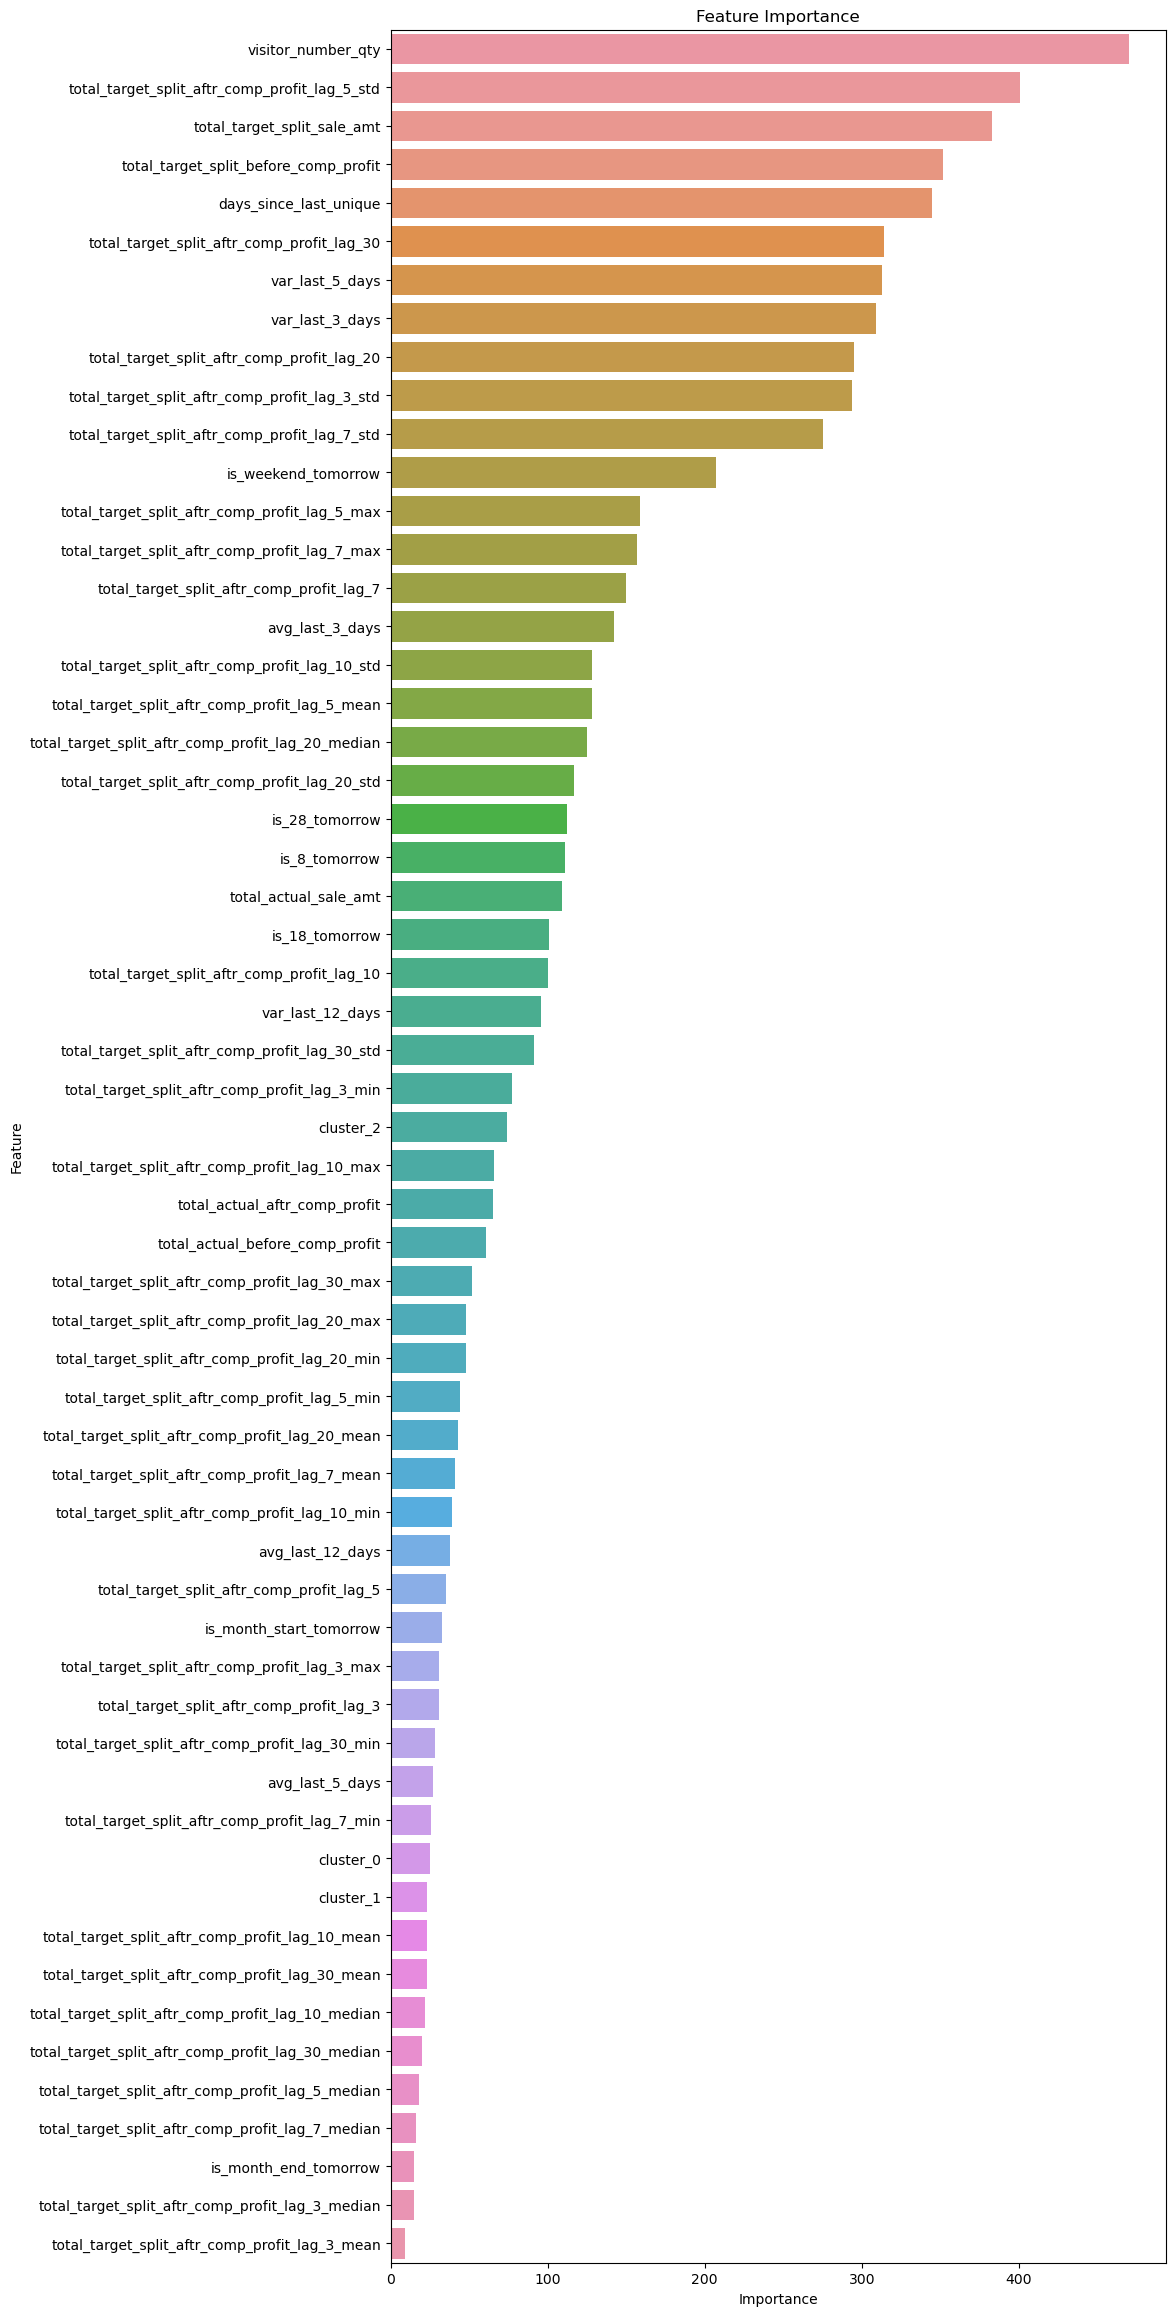

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. 获取特征重要性
feature_importance = lgbm_model.feature_importances_
feature_names = X_train.columns

# 转化为DataFrame以便于排序和可视化
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 2. 使用seaborn绘制横向柱状图
plt.figure(figsize=(10, len(feature_names) * 0.5))  # 调整图像大小
sns.barplot(data=importance_df, y='Feature', x='Importance')
plt.title('Feature Importance')
plt.show()